In [ ]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        fill_mode='nearest' )

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					 class_mode=None,
					shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
import datetime
import time

#Default dimensions we found online
IMG_HEIGHT=224
IMG_WIDTH = 224
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets
train_data_dir = 'C:/Users/websp/Downloads/observations-master/experiements/dest_folder/train' 
validation_data_dir = 'C:/Users/websp/Downloads/observations-master/experiements/dest_folder/val' 
test_data_dir = 'C:/Users/websp/Downloads/observations-master/experiements/dest_folder/test'
 
# number of epochs to train top model 
epochs = 20 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 2

#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(
					rescale=1./255,
					
					fill_mode='nearest') 
#needed to create the bottleneck .npy files

#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					 class_mode=None,
					shuffle=False)

nb_train_samples = len(train_generator.filenames) 
num_classes = len(train_generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(train_generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#validation
start = datetime.datetime.now()
valid_datagen = ImageDataGenerator(rescale=1./255,
                                        fill_mode='nearest' )
validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(width,  heigh), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_validation_samples = len(validation_generator.filenames) 
num_classes = len(validation_generator.class_indices) 
 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 
 
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(width, heigh), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

#validation data
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(width, heigh), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_validation_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('bottleneck_features_validation.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels, 
   epochs=30,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,     verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()



AttributeError: ignored

[INFO] loading and preprocessing image…
ID: 0, Label: with_mask 100.0%
ID: 1, Label: without_mask 0.0%
Final Decision:
.
..
...
ID: 0, Label: with_mask


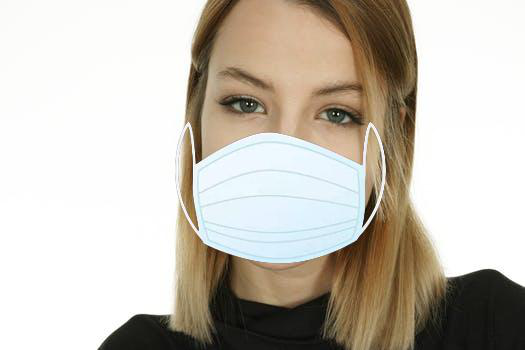

In [ ]:
def read_image(file_path):
   print("[INFO] loading and preprocessing image…") 
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image
def test_single_image(path):
  types = ['with_mask', 'without_mask']
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict_proba(bt_prediction)
  for idx, types, x in zip(range(0,6), types , preds[0]):
   print("ID: {}, Label: {} {}%".format(idx, types, round(x*100,2) ))
  print('Final Decision:')
  time.sleep(.5)
  for x in range(3):
   print('.'*(x+1))
   time.sleep(.2)
  class_predicted = model.predict_classes(bt_prediction)
  class_dictionary = generator_top.class_indices 
  inv_map = {v: k for k, v in class_dictionary.items()} 
  print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
  return load_img(path)
path = 'C:/Users/websp/Downloads/observations-master/experiements/dest_folder/test/with_mask/1-with-mask.jpg'
test_single_image(path)

[INFO] loading and preprocessing image…
ID: 0, Label: Baseline_Artifact 100.0%
ID: 1, Label: Bradycardia 0.0%
Final Decision:
.
..
...
ID: 0, Label: with_mask


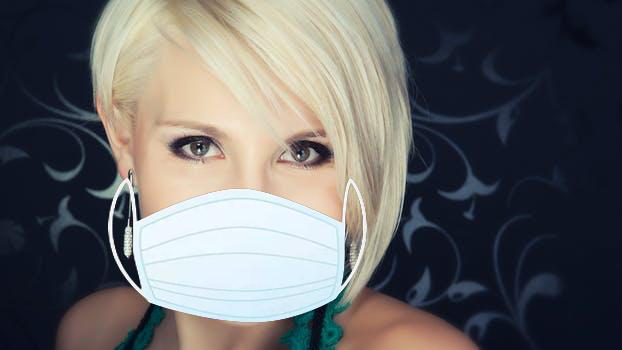

In [ ]:
def read_image(file_path):
   print("[INFO] loading and preprocessing image…") 
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image
def test_single_image(path):
  types = ['Baseline_Artifact', 'Bradycardia', 'Ischaemia', 'Normal']
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict_proba(bt_prediction)
  for idx, types, x in zip(range(0,6), types , preds[0]):
   print("ID: {}, Label: {} {}%".format(idx, types, round(x*100,2) ))
  print('Final Decision:')
  time.sleep(.5)
  for x in range(3):
   print('.'*(x+1))
   time.sleep(.2)
  class_predicted = model.predict_classes(bt_prediction)
  class_dictionary = generator_top.class_indices 
  inv_map = {v: k for k, v in class_dictionary.items()} 
  print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
  return load_img(path)
path = 'C:/Users/websp/Downloads/observations-master/experiements/dest_folder/test/with_mask/5-with-mask.jpg'
test_single_image(path)